In [1]:
!ls

EDA.ipynb  ondemand  scratch


In [10]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 3.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import platform
import sys
import subprocess
import shlex
import json
import os
import csv
import concurrent.futures
from PIL import Image  # Pillow
import openpyxl
import warnings

# import torch
# print(torch.version.cuda)

In [3]:
"""
detect_system_accelerators.py

Purpose:
  - Print a clear summary of CPU and GPU information detected on the current machine.
  - Return a `system_info` dictionary containing structured info.

Notes:
  - Some parts use optional packages. The script will try them if installed, otherwise fall back
    to system commands where possible.
  - If you want more detailed output from optional packages, install them:
      pip install py-cpuinfo psutil GPUtil nvidia-ml-py3 torch tensorflow
"""

def safe_call(cmd):
    """Run command and return stdout (str) or None on error."""
    try:
        out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, universal_newlines=True)
        return out.strip()
    except Exception:
        return None

# ---------------------
# CPU info
# ---------------------
def get_cpu_info():
    """Try multiple methods to get detailed CPU info."""
    info = {}
    info['platform'] = platform.platform()
    info['system'] = platform.system()
    info['machine'] = platform.machine()
    info['processor'] = platform.processor() or None

    # psutil for counts (optional)
    try:
        import psutil
        info['logical_cores'] = psutil.cpu_count(logical=True)
        info['physical_cores'] = psutil.cpu_count(logical=False)
        try:
            info['cpu_freq_mhz'] = psutil.cpu_freq().max if psutil.cpu_freq() else None
        except Exception:
            info['cpu_freq_mhz'] = None
    except Exception:
        info['logical_cores'] = None
        info['physical_cores'] = None
        info['cpu_freq_mhz'] = None

    # py-cpuinfo for human-readable name (optional)
    try:
        import cpuinfo
        ci = cpuinfo.get_cpu_info()
        # vendor_id, brand_raw, hz_advertised_friendly etc
        info['cpu_brand_raw'] = ci.get('brand_raw') or ci.get('brand') or None
        info['cpu_arch'] = ci.get('arch') or None
        info['bits'] = ci.get('bits') or None
    except Exception:
        # fallback to lscpu (Linux) or sysctl (mac), or wmic (Windows)
        info.setdefault('cpu_brand_raw', None)
        info.setdefault('cpu_arch', None)
        info.setdefault('bits', None)

        if info['system'] == 'Linux':
            out = safe_call("lscpu")
            if out:
                # parse some fields
                for line in out.splitlines():
                    if ':' not in line:
                        continue
                    k, v = [x.strip() for x in line.split(':', 1)]
                    if k == "Model name":
                        info['cpu_brand_raw'] = info['cpu_brand_raw'] or v
                    if k == "Architecture":
                        info['cpu_arch'] = info['cpu_arch'] or v
                    if k == "CPU op-mode(s)":
                        info['bits'] = info['bits'] or v
        elif info['system'] == 'Darwin':  # macOS
            out = safe_call("sysctl -n machdep.cpu.brand_string")
            if out:
                info['cpu_brand_raw'] = info['cpu_brand_raw'] or out
            out2 = safe_call("uname -m")
            if out2:
                info['cpu_arch'] = info['cpu_arch'] or out2
        elif info['system'] == 'Windows':
            out = safe_call("wmic cpu get Name,NumberOfCores,NumberOfLogicalProcessors /format:list")
            if out:
                for line in out.splitlines():
                    if '=' not in line:
                        continue
                    k, v = line.split('=', 1)
                    if k.strip() == 'Name' and v.strip():
                        info['cpu_brand_raw'] = info['cpu_brand_raw'] or v.strip()
                    if k.strip() == 'NumberOfCores':
                        try:
                            info['physical_cores'] = info['physical_cores'] or int(v.strip())
                        except Exception:
                            pass
                    if k.strip() == 'NumberOfLogicalProcessors':
                        try:
                            info['logical_cores'] = info['logical_cores'] or int(v.strip())
                        except Exception:
                            pass

    return info

# ---------------------
# GPU info
# ---------------------
def get_gpu_info():
    """
    Attempt to detect GPUs with multiple fallbacks:
      1) PyTorch (torch.cuda)
      2) TensorFlow
      3) NVIDIA NVML (pynvml)
      4) nvidia-smi command
      5) GPUtil package
      6) OS-level queries (lspci / wmic / system_profiler)
    Returns a list of GPU dicts or [] if none found.
    """
    gpus = []

    # 1) PyTorch
    try:
        import torch
        if torch.cuda.is_available():
            count = torch.cuda.device_count()
            for i in range(count):
                props = torch.cuda.get_device_properties(i)
                gpus.append({
                    "provider": "pytorch",
                    "index": i,
                    "name": str(props.name),
                    "total_memory_MB": int(props.total_memory / 1024 / 1024) if hasattr(props, "total_memory") else None,
                    "capability": f"{props.major}.{props.minor}" if hasattr(props, "major") else None,
                })
        # also check MPS (Apple Metal) for Apple silicon
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            gpus.append({"provider": "pytorch_mps", "name": "Apple MPS (Metal) available"})
    except Exception:
        pass

    # 2) TensorFlow
    try:
        import tensorflow as tf
        try:
            tf_gpus = tf.config.list_physical_devices('GPU')
            for idx, dev in enumerate(tf_gpus):
                gpus.append({
                    "provider": "tensorflow",
                    "index": idx,
                    "name": dev.name if hasattr(dev, "name") else str(dev),
                })
        except Exception:
            pass
    except Exception:
        pass

    # 3) NVIDIA NVML (pynvml)
    if not gpus:
        try:
            import pynvml
            pynvml.nvmlInit()
            device_count = pynvml.nvmlDeviceGetCount()
            for i in range(device_count):
                handle = pynvml.nvmlDeviceGetHandleByIndex(i)
                name = pynvml.nvmlDeviceGetName(handle).decode('utf-8') if isinstance(pynvml.nvmlDeviceGetName(handle), bytes) else pynvml.nvmlDeviceGetName(handle)
                mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                gpus.append({
                    "provider": "pynvml",
                    "index": i,
                    "name": name,
                    "total_memory_MB": int(mem_info.total / 1024 / 1024),
                })
            pynvml.nvmlShutdown()
        except Exception:
            pass

    # 4) nvidia-smi (CLI)
    if not gpus:
        out = safe_call("nvidia-smi --query-gpu=index,name,memory.total --format=csv,noheader,nounits")
        if out:
            for line in out.splitlines():
                parts = [p.strip() for p in line.split(',', 2)]
                if len(parts) >= 3:
                    idx, name, mem = parts[0], parts[1], parts[2]
                    try:
                        mem_mb = int(mem)
                    except Exception:
                        mem_mb = None
                    gpus.append({
                        "provider": "nvidia-smi",
                        "index": int(idx) if idx.isdigit() else idx,
                        "name": name,
                        "total_memory_MB": mem_mb,
                    })

    # 5) GPUtil (package)
    if not gpus:
        try:
            import GPUtil
            devs = GPUtil.getGPUs()
            for d in devs:
                gpus.append({
                    "provider": "gputil",
                    "index": int(d.id),
                    "name": d.name,
                    "total_memory_MB": getattr(d, 'memoryTotal', None),
                })
        except Exception:
            pass

    # 6) OS-level generic queries if still nothing found
    if not gpus:
        system = platform.system()
        if system == "Linux":
            # try lspci to look for VGA/3D controllers
            out = safe_call("lspci -vnn | grep -i -E 'vga|3d|display' -A 1")
            if out:
                # crude parsing
                lines = out.splitlines()
                for ln in lines:
                    # skip empty or lines with "Kernel driver"
                    if ln.strip() == "" or ln.strip().startswith("Kernel"):
                        continue
                    # capture vendor/name after device id
                    gpus.append({"provider": "lspci", "name": ln.strip()})
        elif system == "Darwin":
            out = safe_call("system_profiler SPDisplaysDataType -json")
            if out:
                try:
                    sp = json.loads(out)
                    displays = sp.get("SPDisplaysDataType", [])
                    for disp in displays:
                        name = disp.get("sppci_model") or disp.get("sppci_vram") or str(disp)
                        gpus.append({"provider": "system_profiler", "name": name, "details": disp})
                except Exception:
                    gpus.append({"provider": "system_profiler", "raw": out})
        elif system == "Windows":
            out = safe_call("wmic path win32_VideoController get name,AdapterRAM /format:list")
            if out:
                for chunk in out.split("\n\n"):
                    chunk = chunk.strip()
                    if not chunk:
                        continue
                    info = {}
                    for line in chunk.splitlines():
                        if '=' not in line:
                            continue
                        k, v = line.split('=', 1)
                        info[k.strip()] = v.strip()
                    if info:
                        name = info.get("Name") or "unknown"
                        ram = info.get("AdapterRAM")
                        mem_mb = None
                        try:
                            mem_mb = int(ram) // (1024**2) if ram else None
                        except Exception:
                            mem_mb = None
                        gpus.append({"provider": "wmic", "name": name, "total_memory_MB": mem_mb})

    # Deduplicate by name if multiple providers returned duplicates
    seen = set()
    clean = []
    for g in gpus:
        key = (str(g.get("name")), str(g.get("total_memory_MB")))
        if key in seen:
            continue
        seen.add(key)
        clean.append(g)

    return clean

# ---------------------
# Run and print a summary
# ---------------------
def main():
    cpu = get_cpu_info()
    gpus = get_gpu_info()

    system_info = {
        "cpu": cpu,
        "gpus": gpus
    }

    # Print a pretty summary
    print("\n=== CPU SUMMARY ===")
    print(f"System: {cpu.get('system')}  Platform: {cpu.get('platform')}")
    print(f"Machine: {cpu.get('machine')}")
    if cpu.get('cpu_brand_raw'):
        print(f"CPU: {cpu.get('cpu_brand_raw')}")
    elif cpu.get('processor'):
        print(f"CPU (processor): {cpu.get('processor')}")
    else:
        print("CPU: (brand unknown)")

    print(f"Physical cores: {cpu.get('physical_cores')}, Logical cores: {cpu.get('logical_cores')}")
    if cpu.get('cpu_freq_mhz'):
        print(f"Max frequency (MHz): {cpu.get('cpu_freq_mhz')}")
    if cpu.get('cpu_arch'):
        print(f"Architecture: {cpu.get('cpu_arch')}")
    if cpu.get('bits'):
        print(f"Bits / op-mode: {cpu.get('bits')}")

    print("\n=== GPU SUMMARY ===")
    if not gpus:
        print("No GPUs detected by the probes (PyTorch / TensorFlow / nvml / nvidia-smi / GPUtil / OS queries).")
        print("If you expect a GPU (NVIDIA/AMD/Apple), consider installing one of the optional packages:")
        print("  pip install torch tensorflow pynvml GPUtil py-cpuinfo psutil")
    else:
        for idx, g in enumerate(gpus):
            print(f"GPU #{idx}: provider={g.get('provider')}, name={g.get('name')}, total_memory_MB={g.get('total_memory_MB', 'unknown')}")

    # Also print JSON for programmatic consumption
    print("\n=== JSON OUTPUT ===")
    print(json.dumps(system_info, indent=2))

    return system_info

if __name__ == "__main__":
    info = main()



=== CPU SUMMARY ===
System: Linux  Platform: Linux-5.14.0-503.40.1.el9_5.x86_64-x86_64-with-glibc2.34
Machine: x86_64
CPU: AMD EPYC 7452 32-Core Processor
Physical cores: 64, Logical cores: 64
Max frequency (MHz): 2350.0
Architecture: x86_64
Bits / op-mode: 32-bit, 64-bit

=== GPU SUMMARY ===
GPU #0: provider=nvidia-smi, name=NVIDIA A100 80GB PCIe, total_memory_MB=81920

=== JSON OUTPUT ===
{
  "cpu": {
    "platform": "Linux-5.14.0-503.40.1.el9_5.x86_64-x86_64-with-glibc2.34",
    "system": "Linux",
    "machine": "x86_64",
    "processor": "x86_64",
    "logical_cores": 64,
    "physical_cores": 64,
    "cpu_freq_mhz": 2350.0,
    "cpu_brand_raw": "AMD EPYC 7452 32-Core Processor",
    "cpu_arch": "x86_64",
    "bits": "32-bit, 64-bit"
  },
  "gpus": [
    {
      "provider": "nvidia-smi",
      "index": 0,
      "name": "NVIDIA A100 80GB PCIe",
      "total_memory_MB": 81920
    }
  ]
}


Scanning base directory: scratch/stonemt_cameratrap/Camera Trap Photos
Found 56472 image files in total (restricted to allowed years & SM_1..SM_5).

Total images per camera (allowed years):
camera_trap
SM_2    23949
SM_1    19954
SM_3     6247
SM_4     3524
SM_5     2798

Total images per year (allowed years):
year
2022    19091
2023    22965
2024     9766
2025     4650


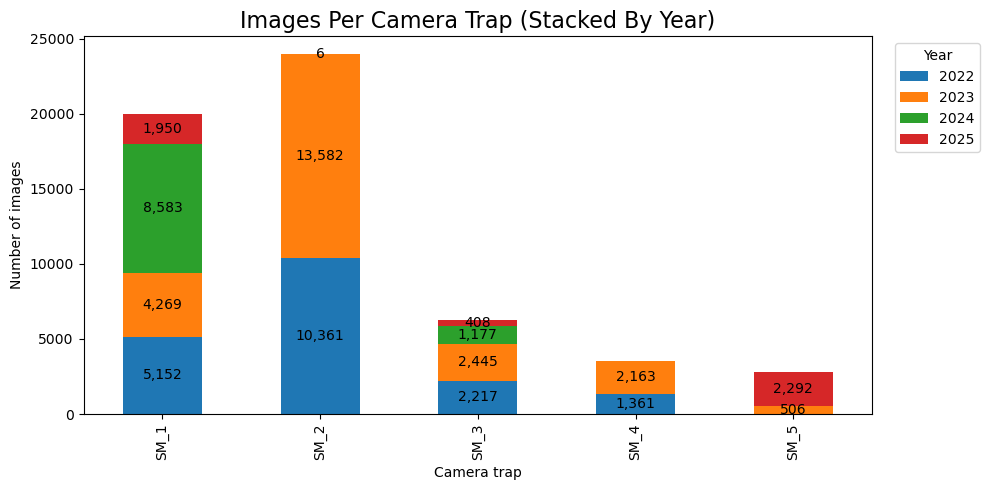

Saved: ondemand/Results/EDA/images_per_camera_by_year.png


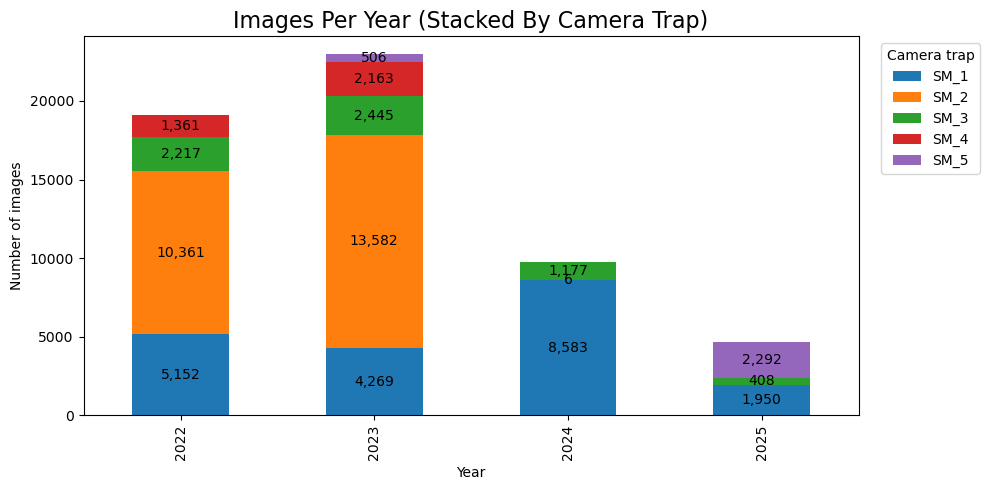

Saved: ondemand/Results/EDA/images_per_year_by_camera.png


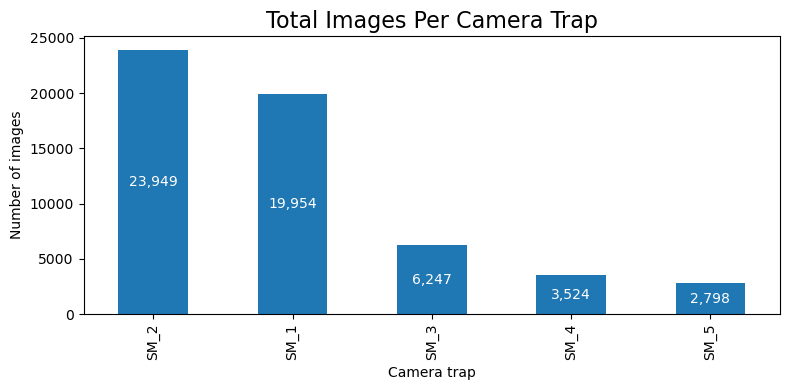

Saved: ondemand/Results/EDA/total_images_per_camera.png


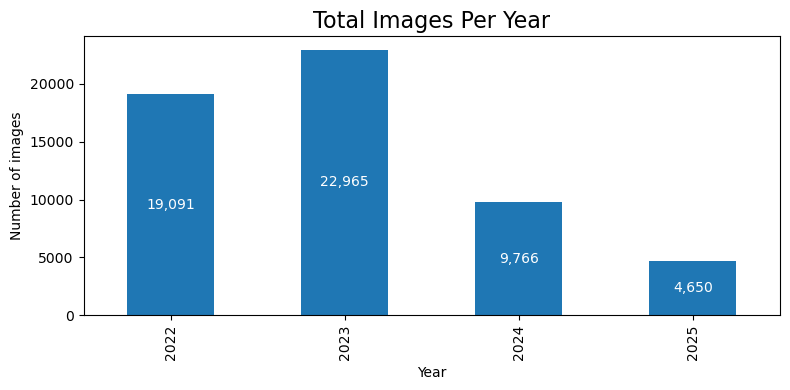

Saved: ondemand/Results/EDA/total_images_per_year.png


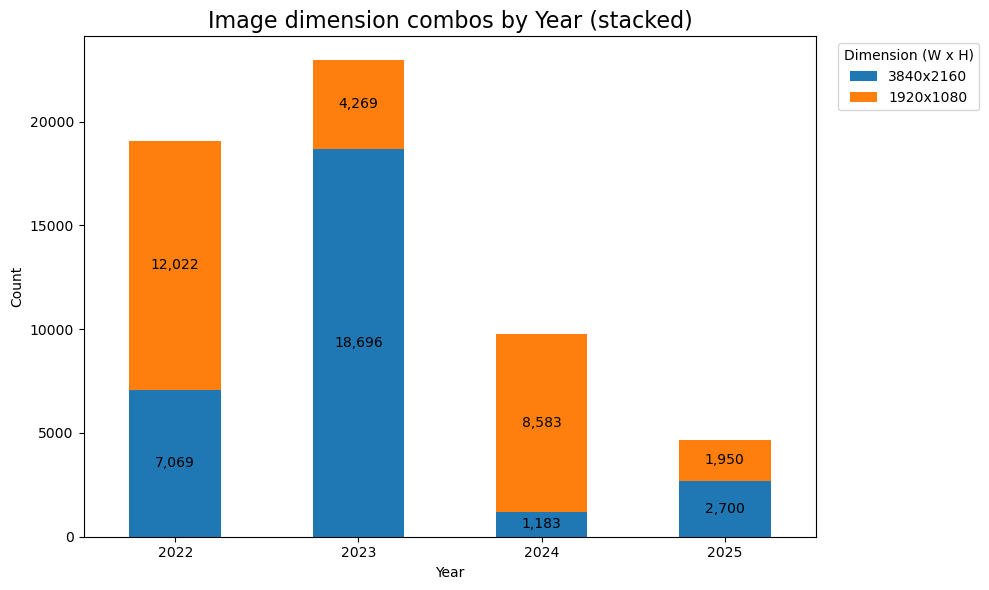

Saved: ondemand/Results/EDA/dimension_combos_by_year_stacked.png


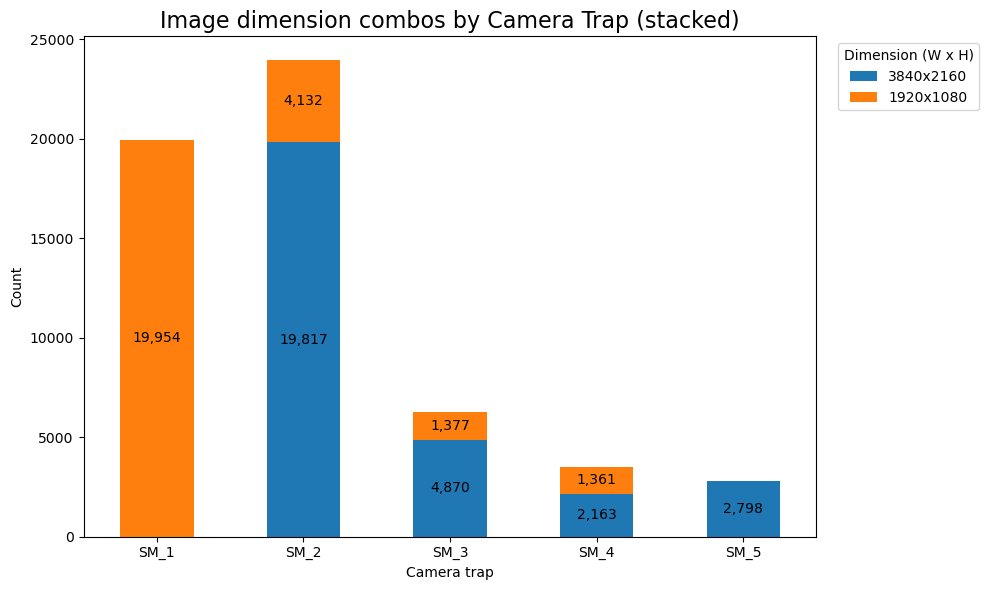

Saved: ondemand/Results/EDA/dimension_combos_by_camera_stacked.png


In [4]:
"""
Camera-trap image summary (restricted years + stacked plots + labeled/condensed images)

Changes:
 - Plot E replaced with two stacked column charts:
     1) Year (x-axis) stacked by dimension combos (Width x Height)
     2) Camera trap (x-axis) stacked by dimension combos
 - Keeps threaded image-dimension reads, header-only parsers (JPEG/PNG), and disk cache.

Requirements:
 - pandas, matplotlib, pillow (PIL)
 - Run in your Python environment that has access to your file system.
"""

# -------------------------
# Configuration
# -------------------------
BASE_DIR = Path("scratch/stonemt_cameratrap/Camera Trap Photos")
CAMERA_NAMES = [f"SM_{i}" for i in range(1, 6)]  # SM_1 .. SM_5
ALLOWED_YEARS = {"2022", "2023", "2024", "2025"}
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# Output paths and image settings
OUT_DIR = Path("ondemand/Results/EDA")
OUT_DIR.mkdir(parents=True, exist_ok=True)
DPI = 600
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 10
DATA_LABEL_FONTSIZE = 10
TICK_LABEL_FONTSIZE = 10

# Cache file for image dimensions
CACHE_PATH = OUT_DIR / "image_dimensions_cache.csv"

# Top-N combos to display explicitly; the rest become "Other"
TOP_N_COMBOS = 20

# -------------------------
# Helper functions
# -------------------------
def extract_year_from_string(s: str):
    """Extract the first '20xx' substring from a folder name."""
    m = re.search(r"(20\d{2})", s)
    return m.group(1) if m else None

def is_image_file(p: Path):
    """Return True if p is a file with a known image extension."""
    return p.is_file() and p.suffix.lower() in ALLOWED_EXTS

def add_data_labels_to_stacked_bars(ax):
    """
    Add comma-separated data labels to each segment of a stacked bar chart.
    Works for pandas-created stacked bars (ax.patches contains rectangles).
    """
    for rect in ax.patches:
        height = rect.get_height()
        if height <= 0:
            continue
        x = rect.get_x() + rect.get_width() / 2.0
        # For stacked bars, rect.get_y() gives bottom of segment
        y = rect.get_y() + height / 2.0
        label = f"{int(round(height)):,}"
        ax.text(x, y, label, ha="center", va="center", fontsize=DATA_LABEL_FONTSIZE)

# -------------------------
# Scanning & collecting records
# -------------------------
def collect_image_records(base_dir: Path):
    """
    Collect image records only from camera folders SM_1..SM_5 and
    only from year subfolders that contain allowed years.
    Returns list of dicts: {"camera_trap": ..., "year": ..., "file_path": ...}
    """
    records = []

    if not base_dir.exists():
        raise FileNotFoundError(f"Base directory does not exist: {base_dir}")

    for cam_name in CAMERA_NAMES:
        cam_dir = base_dir / cam_name
        if not cam_dir.exists() or not cam_dir.is_dir():
            # skip missing camera folders silently
            continue

        # iterate immediate children of camera directory (expected year folders)
        for child in sorted([c for c in cam_dir.iterdir() if c.is_dir()]):
            year_candidate = extract_year_from_string(child.name)
            if year_candidate is None or year_candidate not in ALLOWED_YEARS:
                # skip folders that do not include an allowed year substring
                continue

            # Walk all files under this year folder and count accepted image files
            for img in child.rglob("*"):
                if not is_image_file(img):
                    continue
                records.append({
                    "camera_trap": cam_name,
                    "year": year_candidate,
                    "file_path": str(img),
                })

    return records

# -------------------------
# Caching utilities
# -------------------------
def load_cache(cache_path: Path):
    cache = {}
    if cache_path.exists():
        try:
            with open(cache_path, newline="", encoding="utf-8") as f:
                reader = csv.reader(f)
                for row in reader:
                    if len(row) < 4:
                        continue
                    path, mtime_s, width_s, height_s = row
                    try:
                        cache[path] = {
                            "mtime": float(mtime_s),
                            "width": int(width_s) if width_s != "" else None,
                            "height": int(height_s) if height_s != "" else None,
                        }
                    except Exception:
                        continue
        except Exception:
            return {}
    return cache

def save_cache(cache_path: Path, cache_dict: dict):
    tmp = cache_path.with_suffix(".tmp")
    try:
        with open(tmp, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            for path, meta in cache_dict.items():
                mtime = meta.get("mtime", "")
                width = meta.get("width", "")
                height = meta.get("height", "")
                writer.writerow([path, mtime, width if width is not None else "", height if height is not None else ""])
        tmp.replace(cache_path)
    except Exception as e:
        print(f"Warning: failed to save cache: {e}")

def get_mtime(path: str):
    try:
        return os.path.getmtime(path)
    except Exception:
        return None

# -------------------------
# Fast header-only parsers (JPEG & PNG) + PIL fallback
# -------------------------
def jpeg_dimensions(fp: str):
    try:
        with open(fp, "rb") as f:
            data = f.read(4096)
    except Exception:
        return (None, None)
    if len(data) < 2 or data[0:2] != b'\xff\xd8':
        return (None, None)
    i = 2
    while i < len(data):
        if data[i] != 0xFF:
            i += 1
            continue
        while i < len(data) and data[i] == 0xFF:
            i += 1
        if i >= len(data):
            break
        marker = data[i]
        i += 1
        if marker == 0xD8 or marker == 0xD9:
            continue
        if i + 1 >= len(data):
            break
        length = int.from_bytes(data[i:i+2], "big")
        if length < 2:
            break
        if 0xC0 <= marker <= 0xC3:
            start = i + 2
            if start + 5 <= len(data):
                try:
                    height = int.from_bytes(data[start+1:start+3], "big")
                    width = int.from_bytes(data[start+3:start+5], "big")
                    return (width, height)
                except Exception:
                    return (None, None)
            else:
                return (None, None)
        i += length
    return (None, None)

def png_dimensions(fp: str):
    try:
        with open(fp, "rb") as f:
            sig = f.read(8)
            if sig != b"\x89PNG\r\n\x1a\n":
                return (None, None)
            chunk_len = f.read(4)
            chunk_type = f.read(4)
            if len(chunk_type) < 4 or chunk_type != b'IHDR':
                return (None, None)
            ihdr = f.read(13)
            if len(ihdr) < 8:
                return (None, None)
            width = int.from_bytes(ihdr[0:4], "big")
            height = int.from_bytes(ihdr[4:8], "big")
            return (width, height)
    except Exception:
        return (None, None)

def get_image_size_fast(fp: str):
    ext = os.path.splitext(fp)[1].lower()
    if ext in (".jpg", ".jpeg"):
        dims = jpeg_dimensions(fp)
        if dims != (None, None):
            return dims
    if ext == ".png":
        dims = png_dimensions(fp)
        if dims != (None, None):
            return dims
    try:
        with Image.open(fp) as im:
            return im.size
    except Exception:
        return (None, None)

# -------------------------
# Parallel collection of dims
# -------------------------
def collect_dims_with_threads(file_paths, max_workers=None, use_fast_parser=True):
    if max_workers is None:
        max_workers = min(32, (os.cpu_count() or 4) * 4)

    results = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as exe:
        fut_to_path = {}
        for p in file_paths:
            if use_fast_parser:
                fut = exe.submit(get_image_size_fast, p)
            else:
                fut = exe.submit(get_image_size_fast, p)
            fut_to_path[fut] = p

        for fut in concurrent.futures.as_completed(fut_to_path):
            p = fut_to_path[fut]
            try:
                results[p] = fut.result()
            except Exception:
                results[p] = (None, None)
    return results

# -------------------------
# Summarize and plot (stacked charts)
# -------------------------
def summarize_and_save_plots(records, max_workers=None, top_n_combos=TOP_N_COMBOS):
    """
    Build DataFrame, compute pivot tables, and create stacked column charts:
      - Images per camera (stacked by year)
      - Images per year (stacked by camera)
      - Plot E replaced by:
          1) Year x Dimension-combo stacked chart
          2) Camera trap x Dimension-combo stacked chart
    """
    if len(records) == 0:
        print("No image records found for allowed years. Exiting.")
        return

    df = pd.DataFrame(records)
    df["count"] = 1

    # pivot: camera x year
    pivot_cam_year = df.pivot_table(
        index="camera_trap", columns="year", values="count", aggfunc="sum", fill_value=0
    ).sort_index()

    col_order = sorted(list(ALLOWED_YEARS))
    col_order = [c for c in col_order if c in pivot_cam_year.columns]
    pivot_cam_year = pivot_cam_year[col_order]

    pivot_year_cam = pivot_cam_year.T

    # Print basic summaries
    total_by_camera = pivot_cam_year.sum(axis=1).sort_values(ascending=False)
    total_by_year = pivot_year_cam.sum(axis=1).sort_index()
    print("\nTotal images per camera (allowed years):")
    print(total_by_camera.to_string())
    print("\nTotal images per year (allowed years):")
    print(total_by_year.to_string())

    # Save CSVs for record
    pivot_cam_year.to_csv(OUT_DIR / "camera_by_year_counts.csv")
    pivot_year_cam.to_csv(OUT_DIR / "year_by_camera_counts.csv")

    # --- Plot A: Images per camera (stacked by year) ---
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot_cam_year.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title("Images Per Camera Trap (Stacked By Year)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Camera trap", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    add_data_labels_to_stacked_bars(ax)
    ax.legend(title="Year", fontsize=TICK_LABEL_FONTSIZE, title_fontsize=TICK_LABEL_FONTSIZE, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    out_path = OUT_DIR / "images_per_camera_by_year.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot B: Images per year (stacked by camera) ---
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot_year_cam.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title("Images Per Year (Stacked By Camera Trap)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    add_data_labels_to_stacked_bars(ax)
    ax.legend(title="Camera trap", fontsize=TICK_LABEL_FONTSIZE, title_fontsize=TICK_LABEL_FONTSIZE, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    out_path = OUT_DIR / "images_per_year_by_camera.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot C: Total images per camera (single bar, labels inside) ---
    fig, ax = plt.subplots(figsize=(8, 4))
    total_by_camera.plot(kind="bar", ax=ax)
    ax.set_title("Total Images Per Camera Trap", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Camera trap", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    for i, v in enumerate(total_by_camera):
        ax.text(i, v/2 if v is not None else 0, f"{int(v):,}", ha="center", va="center", fontsize=DATA_LABEL_FONTSIZE, color="white", rotation=0)
    plt.tight_layout()
    out_path = OUT_DIR / "total_images_per_camera.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot D: Total images per year (single bar, labels inside) ---
    fig, ax = plt.subplots(figsize=(8, 4))
    total_by_year.plot(kind="bar", ax=ax)
    ax.set_title("Total Images Per Year", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    for i, v in enumerate(total_by_year):
        ax.text(i, v/2 if v is not None else 0, f"{int(v):,}", ha="center", va="center", fontsize=DATA_LABEL_FONTSIZE, color="white", rotation=0)
    plt.tight_layout()
    out_path = OUT_DIR / "total_images_per_year.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # -------------------------
    # Plot E (updated): Two stacked column charts by dimension combos
    #   - Year x Dimension (stacked by combos)
    #   - Camera x Dimension (stacked by combos)
    # -------------------------
    # Prepare file list & load cache
    file_list = df["file_path"].tolist()
    cache = load_cache(CACHE_PATH)
    to_compute = []
    final_dims = {}

    for fp in file_list:
        mtime = get_mtime(fp)
        cached = cache.get(fp)
        if cached and cached.get("mtime") == (mtime if mtime is not None else cached.get("mtime")):
            final_dims[fp] = (cached.get("width"), cached.get("height"))
        else:
            to_compute.append(fp)

    if to_compute:
        print(f"Computing dimensions for {len(to_compute)} images using {max_workers or 'auto'} workers...")
        computed = collect_dims_with_threads(to_compute, max_workers=max_workers, use_fast_parser=True)
        for p, (w, h) in computed.items():
            final_dims[p] = (w, h)
            cache[p] = {"mtime": get_mtime(p) or 0.0, "width": (w if w is not None else ""), "height": (h if h is not None else "")}

    save_cache(CACHE_PATH, cache)

    # Attach widths/heights to dataframe
    widths = []
    heights = []
    for fp in file_list:
        w, h = final_dims.get(fp, (None, None))
        widths.append(w)
        heights.append(h)
    df["width"] = widths
    df["height"] = heights

    # Build combos and counts
    df_dims = df.dropna(subset=["width", "height"]).copy()
    if df_dims.empty:
        print("No valid width/height data available to plot dimension combinations.")
        return

    df_dims["width"] = df_dims["width"].astype(int)
    df_dims["height"] = df_dims["height"].astype(int)
    df_dims["combo"] = df_dims["width"].astype(str) + "x" + df_dims["height"].astype(str)

    # global combo frequency to decide top N
    combo_counts = df_dims["combo"].value_counts()
    top_combos = list(combo_counts.iloc[:top_n_combos].index)
    # ensure consistent ordering: top combos in descending frequency, then 'Other'
    ordered_combos = top_combos.copy()
    if len(combo_counts) > top_n_combos:
        ordered_combos.append("Other")

    # map combos to grouped combos (others -> 'Other')
    df_dims["combo_grouped"] = df_dims["combo"].where(df_dims["combo"].isin(top_combos), other="Other")

    # Pivot: Year x combo_grouped
    pivot_year_combo = (
        df_dims.groupby(["year", "combo_grouped"]).size()
        .unstack(fill_value=0)
    )
    # ensure columns appear in ordered_combos order (if some combos are missing, fill zeros)
    for c in ordered_combos:
        if c not in pivot_year_combo.columns:
            pivot_year_combo[c] = 0
    pivot_year_combo = pivot_year_combo[ordered_combos]

    # Pivot: Camera x combo_grouped
    pivot_camera_combo = (
        df_dims.groupby(["camera_trap", "combo_grouped"]).size()
        .unstack(fill_value=0)
    )
    for c in ordered_combos:
        if c not in pivot_camera_combo.columns:
            pivot_camera_combo[c] = 0
    pivot_camera_combo = pivot_camera_combo[ordered_combos]

    # Save CSVs for review
    pivot_year_combo.to_csv(OUT_DIR / "year_by_dimension_combo_counts.csv")
    pivot_camera_combo.to_csv(OUT_DIR / "camera_by_dimension_combo_counts.csv")

    # --- Plot E1: Year x Dimension (stacked) ---
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_year_combo.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title("Image dimension combos by Year (stacked)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Count", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="x", labelrotation=0, labelsize=TICK_LABEL_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_LABEL_FONTSIZE)
    ax.legend(title="Dimension (W x H)", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=TICK_LABEL_FONTSIZE, title_fontsize=TICK_LABEL_FONTSIZE)
    add_data_labels_to_stacked_bars(ax)
    plt.tight_layout()
    out_path = OUT_DIR / "dimension_combos_by_year_stacked.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot E2: Camera trap x Dimension (stacked) ---
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_camera_combo.reindex(index=CAMERA_NAMES).plot(kind="bar", stacked=True, ax=ax)  # keep camera order consistent
    ax.set_title("Image dimension combos by Camera Trap (stacked)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Camera trap", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Count", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="x", labelrotation=0, labelsize=TICK_LABEL_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_LABEL_FONTSIZE)
    ax.legend(title="Dimension (W x H)", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=TICK_LABEL_FONTSIZE, title_fontsize=TICK_LABEL_FONTSIZE)
    add_data_labels_to_stacked_bars(ax)
    plt.tight_layout()
    out_path = OUT_DIR / "dimension_combos_by_camera_stacked.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

# -------------------------
# Entrypoint
# -------------------------
def main():
    print("Scanning base directory:", BASE_DIR)
    records = collect_image_records(BASE_DIR)
    print(f"Found {len(records)} image files in total (restricted to allowed years & SM_1..SM_5).")
    summarize_and_save_plots(records, max_workers=None, top_n_combos=TOP_N_COMBOS)

if __name__ == "__main__":
    main()

Found 9 data files (csv/xls/xlsx) under scratch/stonemt_cameratrap/Camera Trap Photos
4 files/sheets missing required headers or failed to read. See ondemand/Results/EDA/csv_files_missing_required_headers.csv
Combined dataframe shape before filtering/dedupe: (15707, 10)
Dropping 184 records with missing ImageName. Saved dropped records to ondemand/Results/EDA/dropped_missing_imagename.csv
Dropped 6822 duplicates using ['ImageName','Location'].
Saved combined CSV: ondemand/Results/EDA/combined_selected_columns_deduped.csv
Saved overall counts CSV: ondemand/Results/EDA/counts_per_commonname_overall.csv
Saved overall boxplot PNG: ondemand/Results/EDA/boxplot_counts_per_commonname_overall.png


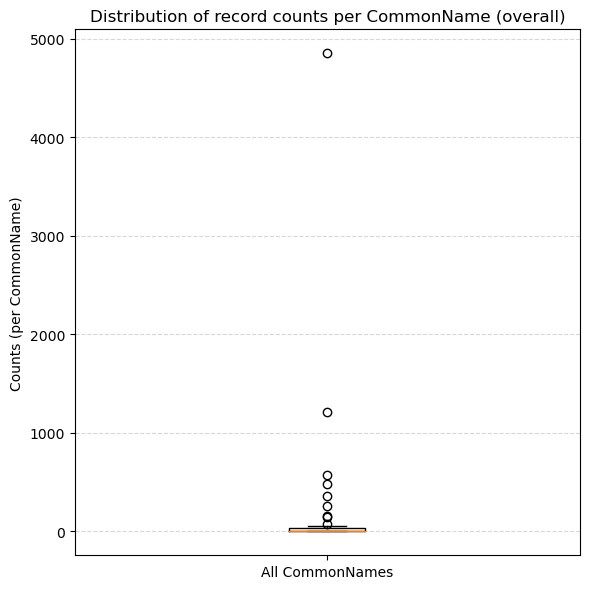

Saved counts pivot CSV: ondemand/Results/EDA/counts_per_commonname_by_year.csv
Saved boxplot by Year PNG: ondemand/Results/EDA/boxplot_counts_per_commonname_by_year.png


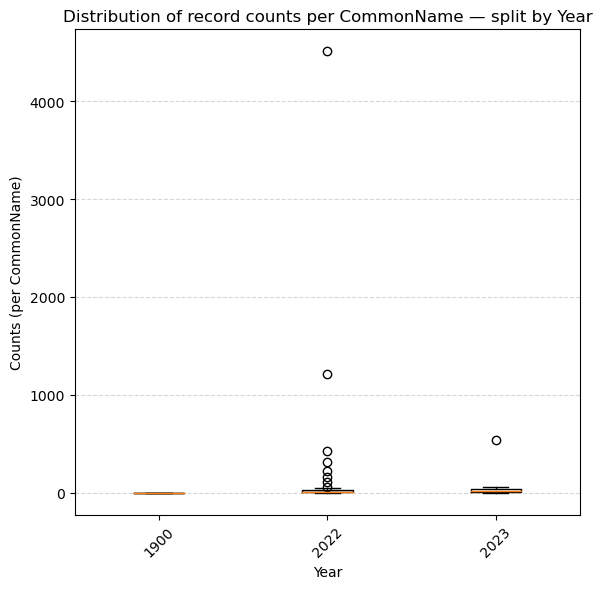

Saved counts pivot CSV: ondemand/Results/EDA/counts_per_commonname_by_location.csv
Saved boxplot by Location PNG: ondemand/Results/EDA/boxplot_counts_per_commonname_by_location.png


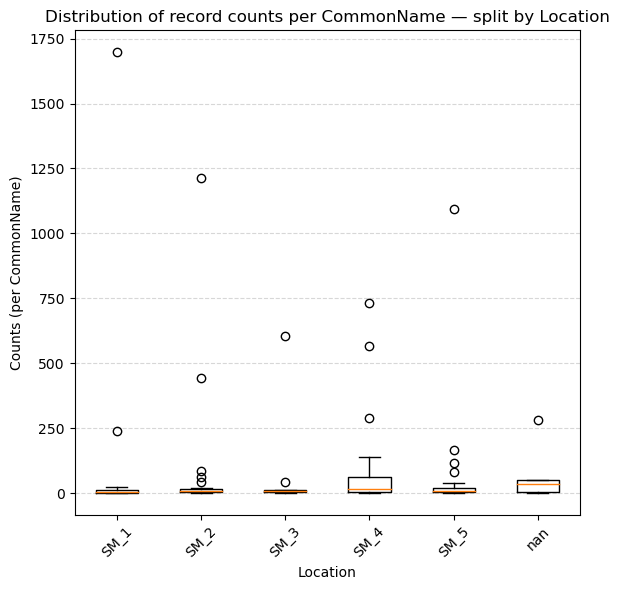


Done. Files written to: ondemand/Results/EDA


In [21]:
#!/usr/bin/env python3
"""
Combine CSV & Excel files, select specific columns, dedupe, and create + show 3 boxplots:
  - Overall counts-per-CommonName (single box)
  - Counts-per-CommonName by TrueDate year (box per year; year taken from TrueDate or CameraDate)
  - Counts-per-CommonName by Location (box per location)

Scans:
  scratch/stonemt_cameratrap/Camera Trap Photos

Outputs (all saved to ondemand/Results/EDA/):
  - combined_selected_columns_deduped.csv
  - csv_files_missing_required_headers.csv
  - dropped_missing_imagename.csv
  - counts_per_commonname_overall.csv
  - counts_per_commonname_by_year.csv
  - counts_per_commonname_by_location.csv
  - boxplot_counts_per_commonname_overall.png
  - boxplot_counts_per_commonname_by_year.png
  - boxplot_counts_per_commonname_by_location.png
"""
import pandas as pd, numpy as np, matplotlib.pyplot as plt, csv, warnings
from pathlib import Path

# -------------------------
# Config
# -------------------------
BASE_DIR = Path("scratch/stonemt_cameratrap/Camera Trap Photos")
OUT_DIR = Path("ondemand/Results/EDA")
OUT_DIR.mkdir(parents=True, exist_ok=True)

REQUIRED_COLS = [
    "Location",
    "ImageName",
    "CameraDate",
    "CameraTime",
    "TrueDate",
    "TrueTime",
    "CommonName",
    "ScientificName",
    "Number",
]

TOP_N_LOCATIONS = 12
PLOT_DPI = 300

# -------------------------
# Utilities
# -------------------------
def normalize_col_name(s: str) -> str:
    return "".join(s.strip().lower().split()).replace("_", "")

def find_data_files(base_dir: Path):
    files = []
    for ext in ("*.csv", "*.xls", "*.xlsx"):
        files.extend(sorted(base_dir.rglob(ext)))
    return files

def map_columns_to_required(actual_headers):
    norm_to_actual = {normalize_col_name(h): h for h in actual_headers}
    mapping = {}
    for req in REQUIRED_COLS:
        mapping[req] = None
        norm_req = normalize_col_name(req)
        if norm_req in norm_to_actual:
            mapping[req] = norm_to_actual[norm_req]
        else:
            for k, v in norm_to_actual.items():
                if norm_req in k or k in norm_req:
                    mapping[req] = v
                    break
    return mapping

def is_missing_imagename_value(s):
    if s is None:
        return True
    try:
        st = str(s).strip()
    except Exception:
        return True
    if st == "":
        return True
    if st.lower() in {"nan", "none", "na", "null"}:
        return True
    return False

# -------------------------
# Read and validate files
# -------------------------
def load_and_combine_tables(base_dir: Path):
    files = find_data_files(base_dir)
    print(f"Found {len(files)} data files (csv/xls/xlsx) under {base_dir}")

    bad_files = []
    tables = []
    for p in files:
        suffix = p.suffix.lower()
        try:
            if suffix == ".csv":
                try:
                    with open(p, newline="", encoding="utf-8") as f:
                        reader = csv.reader(f)
                        header = next(reader, [])
                except Exception:
                    try:
                        header = list(pd.read_csv(p, nrows=0).columns)
                    except Exception:
                        bad_files.append((str(p), "unreadable"))
                        continue

                mapping = map_columns_to_required(header)
                missing = [k for k, v in mapping.items() if v is None]
                if missing:
                    bad_files.append((str(p), missing))
                    continue

                usecols = [mapping[k] for k in REQUIRED_COLS]
                try:
                    df = pd.read_csv(p, usecols=usecols, dtype=str, low_memory=False)
                except Exception as e:
                    try:
                        df = pd.read_csv(p, dtype=str, low_memory=False)
                        df = df[[mapping[k] for k in REQUIRED_COLS]]
                    except Exception:
                        bad_files.append((str(p), f"read_error: {e}"))
                        continue

                rename_map = {mapping[k]: k for k in mapping}
                df = df.rename(columns=rename_map)
                df["_source_file"] = str(p)
                for c in REQUIRED_COLS:
                    if c not in df.columns:
                        df[c] = pd.NA
                tables.append(df)

            elif suffix in (".xls", ".xlsx"):
                try:
                    xls = pd.ExcelFile(p)
                    sheets = xls.sheet_names
                except Exception as e:
                    bad_files.append((str(p), f"excel_read_error: {e}"))
                    continue

                for sheet in sheets:
                    try:
                        header_df = pd.read_excel(p, sheet_name=sheet, nrows=0, dtype=str)
                        header = list(header_df.columns)
                    except Exception as e:
                        bad_files.append((f"{p}::{sheet}", f"header_read_error: {e}"))
                        continue

                    mapping = map_columns_to_required(header)
                    missing = [k for k, v in mapping.items() if v is None]
                    if missing:
                        bad_files.append((f"{p}::{sheet}", missing))
                        continue

                    usecols = [mapping[k] for k in REQUIRED_COLS]
                    try:
                        df = pd.read_excel(p, sheet_name=sheet, usecols=usecols, dtype=str)
                    except Exception as e:
                        try:
                            df = pd.read_excel(p, sheet_name=sheet, dtype=str)
                            df = df[[mapping[k] for k in REQUIRED_COLS]]
                        except Exception:
                            bad_files.append((f"{p}::{sheet}", f"read_error: {e}"))
                            continue

                    rename_map = {mapping[k]: k for k in mapping}
                    df = df.rename(columns=rename_map)
                    df["_source_file"] = f"{p}::{sheet}"
                    for c in REQUIRED_COLS:
                        if c not in df.columns:
                            df[c] = pd.NA
                    tables.append(df)
            else:
                continue
        except Exception as e:
            bad_files.append((str(p), f"unexpected_error: {e}"))
            continue

    bad_list_path = OUT_DIR / "csv_files_missing_required_headers.csv"
    if bad_files:
        pd.DataFrame(bad_files, columns=["file_or_sheet", "missing_or_error"]).to_csv(bad_list_path, index=False)
        print(f"{len(bad_files)} files/sheets missing required headers or failed to read. See {bad_list_path}")
    else:
        pd.DataFrame(columns=["file_or_sheet", "missing_or_error"]).to_csv(bad_list_path, index=False)
        print("All files/sheets had the required headers (or none present).")

    if not tables:
        raise SystemExit("No valid tables to process (all files missing required headers or unreadable).")

    combined = pd.concat(tables, ignore_index=True, sort=False)
    print(f"Combined dataframe shape before filtering/dedupe: {combined.shape}")

    # Drop records with missing ImageName
    combined["ImageName"] = combined["ImageName"].astype(object)
    missing_mask = combined["ImageName"].apply(is_missing_imagename_value)
    num_missing = missing_mask.sum()
    if num_missing > 0:
        dropped_path = OUT_DIR / "dropped_missing_imagename.csv"
        combined.loc[missing_mask].to_csv(dropped_path, index=False)
        print(f"Dropping {num_missing} records with missing ImageName. Saved dropped records to {dropped_path}")
        combined = combined.loc[~missing_mask].copy()
    else:
        print("No records with missing ImageName found.")

    combined["ImageName"] = combined["ImageName"].astype(str).str.strip()
    combined["Location"] = combined["Location"].astype(str).fillna("Unknown").str.strip()

    # Deduplicate
    before = combined.shape[0]
    combined = combined.drop_duplicates(subset=["ImageName", "Location"], keep="first")
    after = combined.shape[0]
    print(f"Dropped {before-after} duplicates using ['ImageName','Location'].")

    # Fill missing TrueDate/TrueTime from CameraDate/CameraTime
    combined["TrueDate"] = combined["TrueDate"].fillna(combined["CameraDate"])
    combined["TrueTime"] = combined["TrueTime"].fillna(combined["CameraTime"])

    # Parse dates
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        combined["TrueDate_parsed"] = pd.to_datetime(combined["TrueDate"], errors="coerce")
        combined["CameraDate_parsed"] = pd.to_datetime(combined["CameraDate"], errors="coerce")

    combined["TrueDate_parsed"] = combined["TrueDate_parsed"].fillna(combined["CameraDate_parsed"])
    combined["TrueYear"] = combined["TrueDate_parsed"].dt.year.astype("Int64")

    combined_out = OUT_DIR / "combined_selected_columns_deduped.csv"
    combined.to_csv(combined_out, index=False)
    print(f"Saved combined CSV: {combined_out}")

    return combined

# -------------------------
# Counting utilities & plotting
# -------------------------
def prepare_counts_overall(df: pd.DataFrame):
    return df.groupby("CommonName").size().sort_values(ascending=False)

def prepare_counts_by_year(df: pd.DataFrame):
    df_valid = df.dropna(subset=["TrueYear"])
    if df_valid.empty:
        return {}
    grouped = df_valid.groupby(["TrueYear", "CommonName"]).size()
    years = sorted(df_valid["TrueYear"].dropna().unique())
    result = {}
    for y in years:
        try:
            s = grouped.loc[y]
            if isinstance(s, pd.Series):
                result[int(y)] = s.sort_values(ascending=False)
            else:
                result[int(y)] = pd.Series({s.index[0]: int(s.values[0])})
        except KeyError:
            result[int(y)] = pd.Series(dtype=int)
    return result

def prepare_counts_by_location(df: pd.DataFrame, top_n_locations=TOP_N_LOCATIONS):
    df = df.copy()
    df["Location"] = df["Location"].fillna("Unknown").astype(str)
    location_totals = df.groupby("Location").size().sort_values(ascending=False)
    unique_locs = list(location_totals.index)
    if len(unique_locs) > top_n_locations:
        chosen = list(location_totals.iloc[:top_n_locations].index)
        df["Location_grouped"] = df["Location"].where(df["Location"].isin(chosen), other="Other")
    else:
        df["Location_grouped"] = df["Location"]
    grouped = df.groupby(["Location_grouped", "CommonName"]).size()
    locations = sorted(df["Location_grouped"].unique(), key=lambda x: (x != "Other", x))
    result = {}
    for loc in locations:
        try:
            s = grouped.loc[loc]
            if isinstance(s, pd.Series):
                result[loc] = s.sort_values(ascending=False)
            else:
                result[loc] = pd.Series(dtype=int)
        except KeyError:
            result[loc] = pd.Series(dtype=int)
    return result

# -------------------------
# Plotting
# -------------------------
def make_boxplot_overall(counts_series, outpath_png, outpath_csv):
    if counts_series is None or counts_series.empty:
        print("No data for overall boxplot.")
        return
    counts_series.to_csv(outpath_csv, header=["count"])
    data = counts_series.values
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.boxplot(data, vert=True, labels=["All CommonNames"])
    ax.set_ylabel("Counts (per CommonName)")
    ax.set_title("Distribution of record counts per CommonName (overall)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    fig.tight_layout()
    fig.savefig(outpath_png, dpi=PLOT_DPI, bbox_inches="tight")
    print(f"Saved overall counts CSV: {outpath_csv}")
    print(f"Saved overall boxplot PNG: {outpath_png}")
    plt.show()
    plt.close(fig)

def make_boxplot_by_category(counts_dict, outpath_png, outpath_csv, xlabel):
    if not counts_dict:
        print(f"No data for boxplot by {xlabel}.")
        return
    pivot_df = pd.DataFrame({str(k): counts_dict[k] for k in counts_dict}).fillna(0).astype(int)
    pivot_df.to_csv(outpath_csv)
    print(f"Saved counts pivot CSV: {outpath_csv}")

    cats = list(counts_dict.keys())
    data, labels = [], []
    for c in cats:
        s = counts_dict[c]
        vals = s.values.tolist() if isinstance(s, pd.Series) else []
        if len(vals) == 0:
            vals = [0]
        data.append([int(v) for v in vals])
        labels.append(str(c))

    width = max(6, len(cats) * 0.8)
    fig, ax = plt.subplots(figsize=(width, 6))
    ax.boxplot(data, labels=labels, vert=True)
    ax.set_ylabel("Counts (per CommonName)")
    ax.set_xlabel(xlabel)
    ax.set_title(f"Distribution of record counts per CommonName — split by {xlabel}")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    fig.tight_layout()
    fig.savefig(outpath_png, dpi=PLOT_DPI, bbox_inches="tight")
    print(f"Saved boxplot by {xlabel} PNG: {outpath_png}")
    plt.show()
    plt.close(fig)

# -------------------------
# Main
# -------------------------
def main():
    combined = load_and_combine_tables(BASE_DIR)
    combined["CommonName"] = combined["CommonName"].fillna("Unknown").astype(str)

    counts_overall = prepare_counts_overall(combined)
    make_boxplot_overall(
        counts_overall,
        outpath_png=OUT_DIR / "boxplot_counts_per_commonname_overall.png",
        outpath_csv=OUT_DIR / "counts_per_commonname_overall.csv",
    )

    counts_by_year = prepare_counts_by_year(combined)
    if counts_by_year:
        years = sorted(counts_by_year.keys())
        pd.DataFrame({y: counts_by_year[y] for y in years}).fillna(0).astype(int).to_csv(
            OUT_DIR / "counts_per_commonname_by_year.csv"
        )
    make_boxplot_by_category(
        counts_by_year,
        outpath_png=OUT_DIR / "boxplot_counts_per_commonname_by_year.png",
        outpath_csv=OUT_DIR / "counts_per_commonname_by_year.csv",
        xlabel="Year",
    )

    counts_by_loc = prepare_counts_by_location(combined, top_n_locations=TOP_N_LOCATIONS)
    if counts_by_loc:
        pd.DataFrame({loc: counts_by_loc[loc] for loc in counts_by_loc}).fillna(0).astype(int).to_csv(
            OUT_DIR / "counts_per_commonname_by_location.csv"
        )
    make_boxplot_by_category(
        counts_by_loc,
        outpath_png=OUT_DIR / "boxplot_counts_per_commonname_by_location.png",
        outpath_csv=OUT_DIR / "counts_per_commonname_by_location.csv",
        xlabel="Location",
    )

    print("\nDone. Files written to:", OUT_DIR)

if __name__ == "__main__":
    main()
